In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from sklearn.base import clone
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import tensorflow as tf
import keras_tuner as kt
import joblib

## Preparing features, target

In [4]:
# Splitting data into features and target.
train_data = pd.read_csv('../data/03_processed_data/clean_train_data.csv')
test_data = pd.read_csv('../data/03_processed_data/clean_test_data.csv')

def split_and_normalize(df, fit_on_train_data=True, scaler=None):
    # Shuffling rows in random order.
    df = df.sample(frac = 1, random_state=42)
    y = df['Clean box office'].reset_index(drop=True)
    X = df.loc[:, df.columns != 'Clean box office']

    # Using normalization instead of standarization because some features aren't normally distributed.
    if fit_on_train_data:
        scaler = MinMaxScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        return X_scaled, y, scaler
    else:
        X_scaled = scaler.transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        return X_scaled, y


X_train, y_train, my_scaler = split_and_normalize(train_data)
X_test, y_test = split_and_normalize(test_data, False, my_scaler)

Baseline Mean Absolute Error (MAE) for train set

In [5]:
y_pred= pd.Series(y_train.mean(), index=y_train.index)
mae = mean_absolute_error(y_train, y_pred)
print('Baseline Mean Absolute Error (MAE):', round(mae))

Baseline Mean Absolute Error (MAE): 117246191


## Linear regression

In [29]:
# Linear regression rather won't be good enough predictor for this problem (not all features are lineary dependent)
# but it is still good to start with it because because it is fast to make and can provide some additional informations.

In [8]:
# Funtion to create and train linear regression model and check coefficients for every feature.
def train_and_coefficients(X_train, y_train):
    # The intercept will be excluded from the model since it yielded negative values, which are nonsensical for box office prediction.
    lin_reg = LinearRegression(fit_intercept=False)
    lin_reg.fit(X_train, y_train)
    coefficients = lin_reg.coef_
    coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})
    coefficients_df = coefficients_df.reindex(coefficients_df['Coefficient'].abs().sort_values(ascending=False).index).reset_index(drop=True)
    # Displaying best and worst features.
    display(coefficients_df.head(10))
    return lin_reg

# Training first model.
lin_reg = train_and_coefficients(X_train, y_train)

,Feature,Coefficient
0,Clean budget,1.005282e+09
1,Previous_movie_box_office,7.770527e+08
2,Max_prev_box_office_director,2.391539e+08
3,Running time,1.522556e+08
4,Streaming,-1.159173e+08
5,Prev_box_office_actors,1.035472e+08
6,G,-7.260930e+07
7,PG,-7.159604e+07
8,R,-7.039875e+07
9,Part_of_franchise,6.136819e+07


Mean Absolute Error (MAE): 61795074
Average MAE (cross-val): 63299093
MAE (cross-val): [60862365. 64053567. 68239523. 62153849. 61186164.]


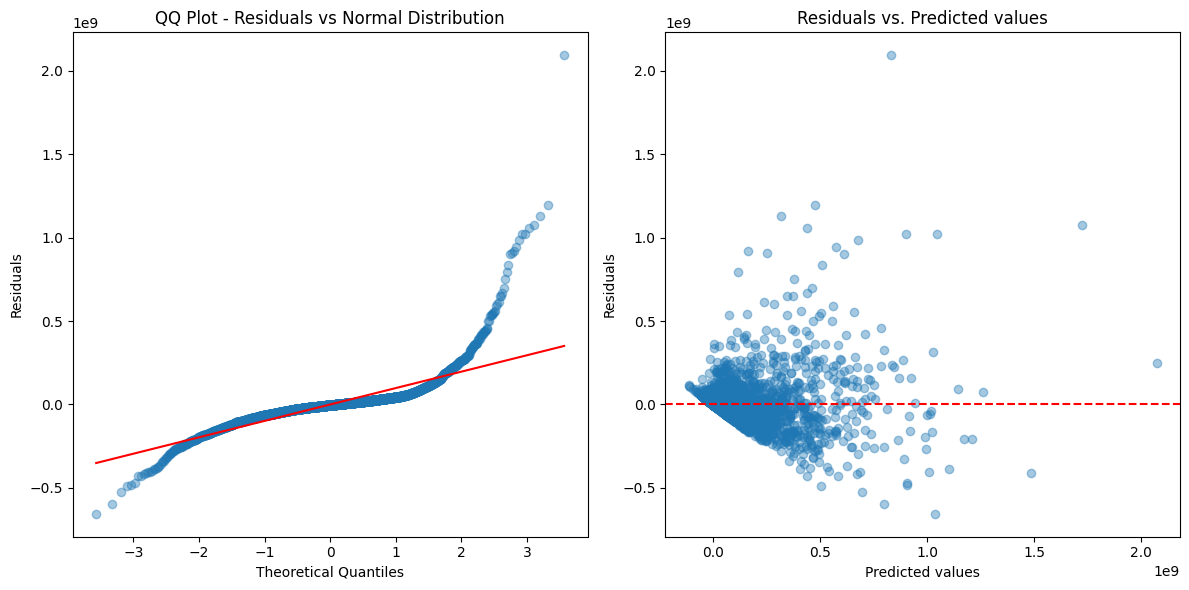

In [9]:
# Due to the presence of significant outliers in the box office results observed during data exploration,
# I opted for MAE over RMSE to assess the model's performance.
# Additionally, MAE offers greater ease of interpretation, further supporting this choice.
def assess_model(model, X, y, logarithmic=False, cross_val_and_print=True, my_cv=5):
    
    y_pred = model.predict(X)
    # If target was logarithmically transformed, then it requires exponential transformation.
    # Ultimately I haven't decided on logarithmical transformation of target because after that SVR and ANN models
    # performed much worse.
    if logarithmic:
        y_pred = np.exp(y_pred)
        y_exp = np.exp(y)
        mae = mean_absolute_error(y_exp, y_pred)
    else:
        mae = mean_absolute_error(y, y_pred)

    # This part executes only if I decide to use cross-validation (so when training the model)
    if cross_val_and_print:
        print('Mean Absolute Error (MAE):', round(mae))
        # Calculating MAE on cross validation.
        if logarithmic:
            skfolds = KFold(n_splits=my_cv)
            cross_mae_scores = []
            for train_index, test_index in skfolds.split(X, y):
                clone_reg = clone(model)
                X_train_folds = X.iloc[train_index, :]
                y_train_folds = y.iloc[train_index]
                X_test_fold = X.iloc[test_index, :]
                y_test_fold = y.iloc[test_index]
                clone_reg.fit(X_train_folds, y_train_folds)
                cross_y_pred = np.exp(clone_reg.predict(X_test_fold))
                cross_y_exp = np.exp(y_test_fold)
                cross_mae_scores.append(mean_absolute_error(cross_y_exp, cross_y_pred))
            cross_mae_scores = np.array(cross_mae_scores)
        else:
            cross_mae_scores = -cross_val_score(model, X, y, cv=my_cv, scoring='neg_mean_absolute_error')

        avg_mae = cross_mae_scores.mean()
        print('Average MAE (cross-val):', round(avg_mae))
        print('MAE (cross-val):', cross_mae_scores.round())
    else:
        return mae


# Control plots for linear regression.
def qq_plot_and_residuals (model, X, y):
    y_pred = model.predict(X)
    residuals = y - y_pred
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # QQ Plot to check if residuals follow normal distribution
    stats.probplot(residuals, dist="norm", plot=axes[0])
    axes[0].get_lines()[0].set_color('tab:blue')
    axes[0].get_lines()[0].set_alpha(0.4)
    axes[0].set_title('QQ Plot - Residuals vs Normal Distribution')
    axes[0].set_xlabel('Theoretical Quantiles')
    axes[0].set_ylabel('Residuals')

    # Residuals vs. Predicted values to check homoskedasticity
    axes[1].scatter(y_pred, residuals, alpha=0.4, color='tab:blue')
    axes[1].set_xlabel('Predicted values')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Residuals vs. Predicted values')
    axes[1].axhline(y=0, color='r', linestyle='--')

    # Adjust layout
    plt.tight_layout()
    plt.show()

assess_model(lin_reg, X_train, y_train)
qq_plot_and_residuals(lin_reg, X_train, y_train)

In [7]:
# As expected and as we can see from the above results the linear regression model is to simple for this task.
# Additionaly conditions such as homoscedasticity of residuals and normal distribution of residuals aren't met.

# Logarithmic transformation on target could improve stabilization of variance but I resigned from this approach
#  because I'm not using linear regression anyway and other models (mostly SVR and ANN) performed worse after this
# transformation.

## Random forest

In [32]:
# Regularization.
# Function to test different parameters with random search method.
def find_best_params(model, my_params, X, y, my_n_iter=10, my_cv=5, my_scoring='neg_mean_absolute_error'):
    rnd_search = RandomizedSearchCV(model, param_distributions=my_params,
                                    cv=my_cv, n_iter=my_n_iter, scoring=my_scoring, random_state=42)
    rnd_search.fit(X, y)
    cv_results = rnd_search.cv_results_
    results_df = pd.DataFrame(cv_results)
    top_10 = results_df[['params', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False).reset_index(drop=True).head(10)
    display(top_10)
    return rnd_search.best_params_

# Parameters to search.
forest_params = {
                  'max_depth': stats.randint(low=8, high=15),
                  # min_samples_leaf below 35 starts to drastically increase gap between train MAE and cross-val MAE.
                  # Above this limit the gap is still quite big because around 5 million but it is stable and increases
                  # slower than cross-val MAE falls so this is why I decided 35 leaf_samples as optimal minimum.
                  'min_samples_leaf': stats.randint(low=35, high=50)
                  }

# Model.
random_forest = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=250)

forest_best_params = find_best_params(random_forest, forest_params, X_train, y_train, 100)

,params,mean_test_score,std_test_score
0,"{'max_depth': 13, 'min_samples_leaf': 35}",-6.013654e+07,3.212645e+06
1,"{'max_depth': 14, 'min_samples_leaf': 35}",-6.013659e+07,3.212593e+06
2,"{'max_depth': 10, 'min_samples_leaf': 35}",-6.014321e+07,3.212003e+06
3,"{'max_depth': 10, 'min_samples_leaf': 35}",-6.014321e+07,3.212003e+06
4,"{'max_depth': 10, 'min_samples_leaf': 35}",-6.014321e+07,3.212003e+06
5,"{'max_depth': 8, 'min_samples_leaf': 35}",-6.023065e+07,3.244160e+06
6,"{'max_depth': 12, 'min_samples_leaf': 36}",-6.024547e+07,3.270364e+06
7,"{'max_depth': 12, 'min_samples_leaf': 36}",-6.024547e+07,3.270364e+06
8,"{'max_depth': 13, 'min_samples_leaf': 36}",-6.024553e+07,3.270153e+06
9,"{'max_depth': 14, 'min_samples_leaf': 36}",-6.024558e+07,3.270101e+06


In [33]:
# Function to create and train random forest model.
def train_forest(X, y, params_variable):
    model = RandomForestRegressor(n_estimators=250, max_depth=params_variable['max_depth'],
                                    min_samples_leaf=params_variable['min_samples_leaf'], n_jobs=-1, random_state=42)
    model.fit(X, y)
    return model

best_random_forest = train_forest(X_train, y_train, forest_best_params)

assess_model(best_random_forest, X_train, y_train)

Mean Absolute Error (MAE): 54967635
Average MAE (cross-val): 60136536
MAE (cross-val): [60066925. 61007687. 65669577. 56683167. 57255325.]


In [13]:
# Function for determing feature importance.
def feature_importance(model, X):
    df_feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
    df_feature_importances = df_feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    display(df_feature_importances.head(10))
    return df_feature_importances

# Feature importance for the best random forest model.
random_forest_features = feature_importance(best_random_forest, X_train)

,Feature,Importance
0,Clean budget,0.877867
1,Previous_movie_box_office,0.054790
2,Part_of_franchise,0.020404
3,Running time,0.010380
4,Max_prev_box_office_director,0.010117
5,Prev_box_office_actors,0.005175
6,Avg_ratings_score_director,0.003925
7,Weekly_budget_ratio,0.002849
8,Year,0.002751
9,Median_main_genre_box_office,0.002170


In [53]:
# Saving model best_random_forest.
joblib.dump(best_random_forest, '../models/trained_random_forest_model.pkl')

['../models/trained_random_forest_model.pkl']

## SVR

In [15]:
# Function to remove features.
def remove_features(X_train, X_test, features):
    new_X_test = X_test.copy()
    new_X_test.drop(features, axis=1, inplace=True)
    new_X_train = X_train.copy()
    new_X_train.drop(features, axis=1, inplace=True)
    return new_X_train, new_X_test

# Removing features with very low importance in random forest to increase performance of SVR which is very computationally heavy.
unimportant_features = random_forest_features.loc[random_forest_features['Importance'] < 0.0021, 'Feature']
X_train_svr, X_test_svr = remove_features(X_train, X_test, unimportant_features)

In [50]:
# The third degree polynomial performed the best out of (2-4 degree), so I took it out of parameters search.
svr_model = SVR(kernel='poly', degree=3)

# Parameters to search.
svm_params = {
                  'gamma': stats.randint(low=130, high=170),
                  'C': stats.randint(low=30, high=50),
                  }

# Regularization.
# Searching for best parameters with random search method.
svr_best_params = find_best_params(svr_model, svm_params, X_train_svr, y_train, 100)

,params,mean_test_score,std_test_score
0,"{'C': 46, 'gamma': 167}",-5.676213e+07,3.639064e+06
1,"{'C': 43, 'gamma': 168}",-5.677094e+07,3.649547e+06
2,"{'C': 48, 'gamma': 161}",-5.677393e+07,3.651954e+06
3,"{'C': 41, 'gamma': 169}",-5.677628e+07,3.652905e+06
4,"{'C': 44, 'gamma': 164}",-5.678124e+07,3.652469e+06
5,"{'C': 44, 'gamma': 161}",-5.678520e+07,3.652289e+06
6,"{'C': 41, 'gamma': 159}",-5.678767e+07,3.659740e+06
7,"{'C': 42, 'gamma': 158}",-5.678784e+07,3.659690e+06
8,"{'C': 44, 'gamma': 155}",-5.678794e+07,3.659617e+06
9,"{'C': 38, 'gamma': 168}",-5.678839e+07,3.654798e+06


In [51]:
# Function to create and train SVM model.
def train_svr(X, y, params_variable):
    model = SVR(kernel='poly', gamma=params_variable['gamma'], C=params_variable['C'])
    model.fit(X, y)
    return model

best_svr = train_svr(X_train_svr, y_train, svr_best_params)

# Assessing SVR model.
assess_model(best_svr, X_train_svr, y_train)

Mean Absolute Error (MAE): 53413116
Average MAE (cross-val): 56762129
MAE (cross-val): [52946440. 56405582. 63660378. 55063015. 55735230.]


In [52]:
# Despite using only 10 features in this model we can see significant improvement over random forest.
# Additionaly there is decrease in difference between train and cross_val sets so this model is less overfitted.

# Saving model best_svm.
joblib.dump(best_svr, '../models/trained_svr_model.pkl')

['../models/trained_svr_model.pkl']

## Artificial neural network

In [54]:
# Function to determine limits for parameters.
def build_model(hp):
    # Defining the range of values for each hyperparameter.
    n_hidden = hp.Int('n_hidden', min_value=3, max_value=7)
    n_neurons = hp.Int('n_neurons', min_value=64, max_value=512, step=32)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='log')
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(48,)))
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model

# Splitting train data to train and validation set.
X_part_train_ann, X_val_ann, y_part_train_ann, y_val_ann = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Looking for optimal parameters with hyperband tuner. Objective is set to minimize MAE on validation dataset. 
# Batch sizes to check.
batch_sizes = [32, 64]
results = []
for batch_size in batch_sizes:
    hyperband_tuner = kt.Hyperband(build_model, objective='val_loss', seed=42, max_epochs=15, factor=3, hyperband_iterations=3,
                                overwrite=True, directory='../models', project_name=f'training_ann_models_{batch_size}')

    # Defining the directory for TensorBoard logs.
    root_logdir = f'../models/training_ann_models_{batch_size}/tensorboard'
    tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)

    # Early stopping to halt training if no improvement is seen.
    stop_early = tf.keras.callbacks.EarlyStopping(patience=3)

    # Searching for the best parameters.
    hyperband_tuner.search(X_part_train_ann, y_part_train_ann, validation_data=(X_val_ann, y_val_ann), callbacks=[stop_early, tensorboard_cb], batch_size=batch_size)

    # Validating the best model for every batch size and saving it in the list.
    best_model = hyperband_tuner.get_best_models(num_models=1)[0]
    val_mae = best_model.evaluate(X_val_ann, y_val_ann)
    results.append({'batch_size': batch_size, 'params': hyperband_tuner.get_best_hyperparameters(num_trials=1)[0], 'val_mae': val_mae})

    tf.keras.backend.clear_session()

# Printing the best results for every batch size.
for result in results:
    print(f"Batch size: {result['batch_size']}, Validation Loss: {result['val_mae']},\nParams: {result['params'].values}")

Trial 90 Complete [00h 00m 20s]
val_loss: 70538080.0

Best val_loss So Far: 54725612.0
Total elapsed time: 00h 15m 26s


d:\NAUKA\My_projects\box_office_project\project_env\Lib\site-packages\keras_tuner\src\tuners\hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
d:\NAUKA\My_projects\box_office_project\project_env\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56922820.0000
Batch size: 32, Validation Loss: 54356992.0,
Params: {'n_hidden': 7, 'n_neurons': 512, 'learning_rate': 0.0007970790759235166, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0072'}
Batch size: 64, Validation Loss: 54725600.0,
Params: {'n_hidden': 7, 'n_neurons': 384, 'learning_rate': 0.0009498462725730985, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0050'}


In [90]:
# Looking at the best models of 32 and 64 batch sizes I decided to choose model witch 32 batch size because
# it was more stable when comparing training and validation datasets.

# Training new model using the best parameters from previous step and finding optimal number of epochs.
best_hyperparams = results[0]['params']
new_model_ann = hyperband_tuner.hypermodel.build(best_hyperparams)
history = new_model_ann.fit(X_part_train_ann, y_part_train_ann, epochs=25, validation_data=(X_val_ann, y_val_ann), batch_size=32)

Epoch 1/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 101327456.0000 - val_loss: 76570472.0000
Epoch 2/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 74815416.0000 - val_loss: 65988652.0000
Epoch 3/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 64369444.0000 - val_loss: 60639116.0000
Epoch 4/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 60437424.0000 - val_loss: 57488568.0000
Epoch 5/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 54396564.0000 - val_loss: 55165012.0000
Epoch 6/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 54924340.0000 - val_loss: 55801660.0000
Epoch 7/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 54290032.0000 - val_loss: 57966440.0000
Epoch 8/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 53115420.0000 - val_loss: 54982512.0000
Epoch 9/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 53848976.0000 - val_loss: 55088372.0000
Epoch 10/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 51638508.0000 - val_loss: 55066336.0000
Epoch 11

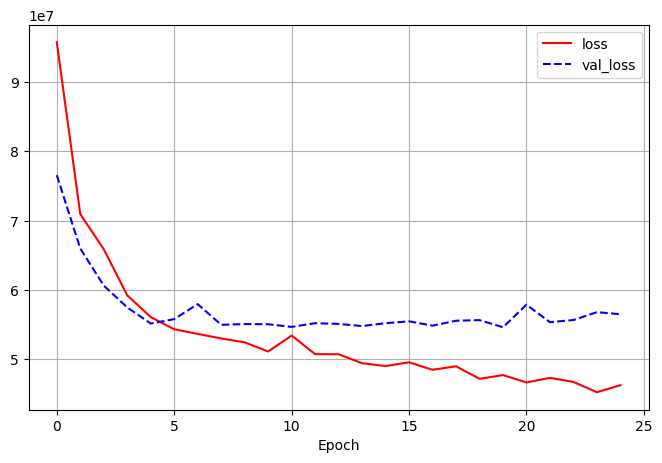

In [91]:
# Vizualization of learning process for the new ANN model.
pd.DataFrame(history.history).plot(
    figsize=(8, 5), grid=True, xlabel='Epoch', style=['r-', 'b--'])
plt.show()

In [105]:
# As seen on the above vizualization MAE's of train and validation sets meet on the 4th epoch.
# This is why I choose to train final model for 4 epochs using early stopping as reguralization method.
# Final model is trained on the full training dataset.
best_ann = hyperband_tuner.hypermodel.build(best_hyperparams)
best_ann.fit(X_train, y_train, epochs=4, batch_size=32)

# Saving model best_ann.
best_ann.save('../models/trained_neural_network_model.keras')

Epoch 1/4
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 107188496.0000
Epoch 2/4
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 70491440.0000
Epoch 3/4
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 60690876.0000
Epoch 4/4
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 54426504.0000


## Models evaluation on test dataset

In [17]:
# After examining the results of the training and validation sets, I would rank the models as follows:
# 1. ANN, 2. SVR, 3. random forest with ANN having similar MAE to SVR but greatly surpassing it on the ability
# of generalization (the difference between train and validation sets was the smallest).

# But let's check performance of all 3 models on test dataset.

# Loading best random forest and SVR models.
best_forest = joblib.load('../models/trained_random_forest_model.pkl')
best_svr = joblib.load('../models/trained_svr_model.pkl')
best_ann = tf.keras.models.load_model('../models/trained_neural_network_model.keras')

# Reults on train dataset.
mae_random_forest_train = assess_model(best_forest, X_train, y_train, cross_val_and_print=False)
mae_svr_train = assess_model(best_svr, X_train_svr, y_train, cross_val_and_print=False)
mae_ann_train = assess_model(best_ann, X_train, y_train, cross_val_and_print=False)

# Evaluation of models on test dataset.
mae_random_forest = assess_model(best_forest, X_test, y_test, cross_val_and_print=False)
mae_svr = assess_model(best_svr, X_test_svr, y_test, cross_val_and_print=False)
mae_ann = assess_model(best_ann, X_test, y_test, cross_val_and_print=False)

# Displaying statistics as DataFrame.
test_results = pd.DataFrame({'Random forest': [mae_random_forest_train, mae_random_forest], 'SVR': [mae_svr_train, mae_svr],
                             'Neural network': [mae_ann_train, mae_ann]})
test_results.index = ['MAE on train dataset', 'MAE on test dataset']
display(test_results)

121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Random forest,SVR,Neural network
MAE on train dataset,5.496764e+07,5.341312e+07,5.400206e+07
MAE on test dataset,6.330592e+07,5.654148e+07,5.536011e+07


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred = best_ann.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)

The models performed as anticipated on the test dataset. Once again, Random Forest emerged as the least favorable solution for this task,  
exhibiting a poor ability to generalize. It is evident that the model is overfitted to the training dataset, with performance on the test data lagging  
by over 8 million dollars. SVR model was better than random forest but achieved much worse MAE on test set than during cross-validation also  
appearing to have problem with generalization. ANN, on the other hand, demonstrated very good performance, consistently showcasing superior  
generalization capabilities. Therefore, I would choose it as the ultimate product of this project.

In [18]:
# Comparing MAE of the final model with descriptive statistics of full dataset.
y_combined = np.concatenate((y_train, y_test))
print(f"Final MAE (test): {mae_ann:.2e}")
print(f"Minimum value: {np.min(y_combined):.2e}")
print(f"Maximum value: {np.max(y_combined):.2e}")
print(f"Median: {np.median(y_combined):.2e}")
print(f"Mean: {np.mean(y_combined):.2e}")
print(f"Standard deviation: {np.std(y_combined):.2e}")

Final MAE (test): 5.54e+07
Minimum value: 5.88e+02
Maximum value: 2.92e+09
Median: 3.14e+07
Mean: 1.03e+08
Standard deviation: 2.03e+08


The final MAE is noticeably higher than the median, suggesting room for improvement in the model's performance. However, it's crucial to acknowledge  
the significant spread in the data, with the minimum value at 588 and the maximum nearing 3 billion. This wide range contributes to a high standard  
deviation of over 200 million.

The model could certainly benefit greatly from insights into the marketing strategies employed for these movies, especially the costs of marketing.  
Unfortunately, such critical information is often tightly guarded by movie studios and rarely available to public.